In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mengambil contoh data polusi Jakarta (Dataset publik harian)
# Kita gunakan data dummy yang strukturnya sama dengan dataset Kaggle Jakarta Air Quality
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
df = pd.read_csv(url)

# Kita fokus pada kolom polusi (pm2.5)
# Jika menggunakan dataset Kaggle Jakarta, ganti nama kolom sesuai file .csv-nya
df = df[['pm2.5']].rename(columns={'pm2.5': 'pm25'})
df = df.fillna(method='ffill') # Mengisi data kosong

print("Lima data pertama:")
print(df.head())

Lima data pertama:
   pm25
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN


/tmp/ipython-input-2624484271.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill') # Mengisi data kosong


In [ ]:
# Sinkronisasi skala data (0 sampai 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Fungsi untuk membuat dataset untuk LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Menggunakan 24 jam sebelumnya untuk memprediksi 1 jam ke depan
WINDOW_SIZE = 24
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split data (80% Train, 20% Test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1) # Output prediksi angka polusi
])

model.compile(optimizer='adam', loss='mse')

# Berhenti jika model sudah tidak membaik (mencegah overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Memulai Training...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Memulai Training...
Epoch 1/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: nan - val_loss: nan
Epoch 2/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: nan - val_loss: nan
Epoch 3/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: nan - val_loss: nan
Epoch 4/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: nan - val_loss: nan
Epoch 5/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: nan - val_loss: nan
Epoch 6/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: nan - val_loss: nan


274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


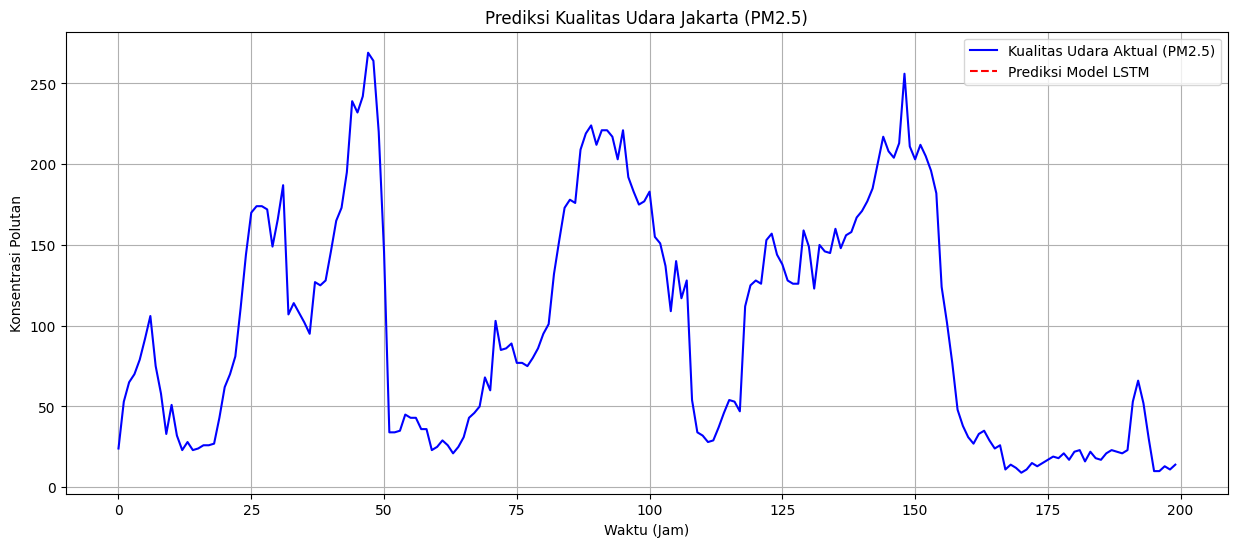

In [ ]:
# Prediksi
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Kembalikan ke angka asli
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Hasil
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:200], label='Kualitas Udara Aktual (PM2.5)', color='blue')
plt.plot(predictions[:200], label='Prediksi Model LSTM', color='red', linestyle='--')
plt.title('Prediksi Kualitas Udara Jakarta (PM2.5)')
plt.xlabel('Waktu (Jam)')
plt.ylabel('Konsentrasi Polutan')
plt.legend()
plt.grid(True)
plt.show()